# Analysis of experiments

The goal of this notebook is to analyse the results from FL experiments, more especially the energy consumption of the experiments and the training rounds.
The preprocessing functions can be found in process_energy.py. They compute statistics (total energy and round energy) for every experiments in the given folders. 
This notebook first shows experiment statistics before studying the round energy consumption.

Tasks:
- [DONE] visualize the evolution of the energy consumption of the server and the clients during the training
- [DONE] visualize the evolution of the local and global loss/accuracy
- [DONE] Compute the local/total energy consumption of each experiments
- Compare experiments
    - complete experiment_summary with 
        - [DONE] final accuacry (centralized, distributed max, dist avg)
        - [DONE] total energy
        - energy per client
        - [DONE] number of rounds to reach accuracy
        - training time
- [DONE] Compute the energy consumption of each round for each hosts/clients
    - [DONE] study the impact of training several clients on one host
- [DONE] Is the energy consumed by each round stable? 
- [DONE] How does the number of epoch impacts it?

Remarks:
- Power is in milliwatts

This notebook requires running preprocess() and aggregate_round_stats() once.

## Imports and paths

In [2]:
import matplotlib.pyplot as plt
import seaborn.objects as so
from seaborn import axes_style
theme_dict = {**axes_style("whitegrid"), "grid.linestyle": ":"}
so.Plot.config.theme.update(theme_dict)
import sys

fl_repo = '/Users/mathildepro/Documents/code_projects/FL-G5K-EnergyConsumption'
# fl_repo = '/home/mjay/FL-G5K-Test'
logs = '/Users/mathildepro/Documents/code_projects/fl_logs/avril24'
# logs = '/home/mjay/energyfl/outputcifar10'

sys.path.append(f'{fl_repo}/src/utils')

from process_energy import preprocess, aggregate_round_stats


In [3]:
outputs_path = [
    f"{logs}/fedyogi/labelskew",
    f"{logs}/fedavg/labelskew",
    f"{logs}/fedadam/labelskew",
    f"{logs}/fedadagrad/labelskew"
]
# preprocess(outputs_path)
# results, round_results = aggregate_round_stats(logs, outputs_path)


The concatenation of march (10 clients per host) and april (1 client per host) logs doesn't work so each need to be analysed separately.

In [4]:
import dask.dataframe as dd

# Read large datasets in parallel
logs = '/Users/mathildepro/Documents/code_projects/fl_logs/mars24'
results_pq_1 = dd.read_parquet(f"{logs}/global_summary.parquet")
round_pq_1 = dd.read_parquet(f"{logs}/round_summary.parquet")

logs = '/Users/mathildepro/Documents/code_projects/fl_logs/avril24'
results_pq_2 = dd.read_parquet(f"{logs}/global_summary.parquet")
round_pq_2 = dd.read_parquet(f"{logs}/round_summary.parquet")


In [206]:
results_pq, round_pq = results_pq_2, round_pq_2

# Experiment energy

In [207]:
results_pq.describe().compute()

,sleep_duration,params.num_rounds,params.num_clients_per_round_fit,params.num_clients_per_round_eval,params.min_available_clients,params.fraction_fit,params.fraction_evaluate,params.wait_round,params.lr,params.num_groups,...,clients_kWh,server_J,server_kWh,total_J,total_kWh,max_centralized_accuracy,max_distributed_accuracy,round_number,nb_hosts,nb_energy_hosts
count,96.0,96.000000,96.0,96.0,96.0,96.000000,96.000000,96.000000,9.600000e+01,96.0,...,96.0,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.0,96.0
mean,30.0,193.812500,2.0,2.0,2.0,0.992708,0.994792,200.000000,1.000000e-02,32.0,...,0.0,57563.244858,0.015990,57563.244858,0.015990,0.757528,0.759704,193.812500,0.0,0.0
std,0.0,154.713407,0.0,0.0,0.0,0.071443,0.051031,152.867332,1.743830e-18,0.0,...,0.0,36032.800068,0.010009,36032.800068,0.010009,0.138646,0.138617,154.713407,0.0,0.0
min,30.0,3.000000,2.0,2.0,2.0,0.300000,0.500000,100.000000,1.000000e-02,32.0,...,0.0,119.382091,0.000033,119.382091,0.000033,0.100000,0.100521,3.000000,0.0,0.0
25%,30.0,100.000000,2.0,2.0,2.0,1.000000,1.000000,100.000000,1.000000e-02,32.0,...,0.0,36441.720370,0.010123,36441.720370,0.010123,0.776400,0.777333,100.000000,0.0,0.0
50%,30.0,100.000000,2.0,2.0,2.0,1.000000,1.000000,100.000000,1.000000e-02,32.0,...,0.0,46596.041338,0.012943,46596.041338,0.012943,0.789000,0.789748,100.000000,0.0,0.0
75%,30.0,300.000000,2.0,2.0,2.0,1.000000,1.000000,300.000000,1.000000e-02,32.0,...,0.0,77998.533250,0.021666,77998.533250,0.021666,0.795450,0.796656,300.000000,0.0,0.0
max,30.0,1000.000000,2.0,2.0,2.0,1.000000,1.000000,1000.000000,1.000000e-02,32.0,...,0.0,291716.446764,0.081032,291716.446764,0.081032,0.808000,0.823480,1000.000000,0.0,0.0


In [208]:
# results_pq[[x for x in results_pq if "estats" in x]] = results_pq[[x for x in results_pq if "estats" in x]].fillna("")
# results_pq["total_kWh"] = results_pq["total_kWh"].fillna(0)
# results_pq = results_pq.dropna()

In [209]:
parameters = [
    # 'server', 
    # 'params.num_clients_per_round_fit',
    # 'params.num_clients_per_round_eval',
    "strategy", 
    'data.num_clients',
    # 'params.min_available_clients', 
    # 'neuralnet',
    # 'optimizer',
    'data.batch_size', 
    'client.lr',
    "params.fraction_fit",	
    'client.local_epochs', 
    'params.wait_round', #'params.num_rounds',
    ]
# results.groupby(parameters)[["total_kWh"]].count().style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)
agg = results_pq.groupby(parameters)[["total_kWh"]].count().rename(columns={"total_kWh":"count"})
agg.compute().style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

In [210]:

perf_metrics = [
    "total_kWh",
    "max_centralized_accuracy", 
    "max_distributed_accuracy", 
    "round_number"
    ]
# results.groupby(parameters)[perf_metrics].mean().style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)
results_pq.groupby(parameters)[perf_metrics].mean().compute().style.background_gradient(cmap='viridis', low=0.2, high=0.2, axis=0)

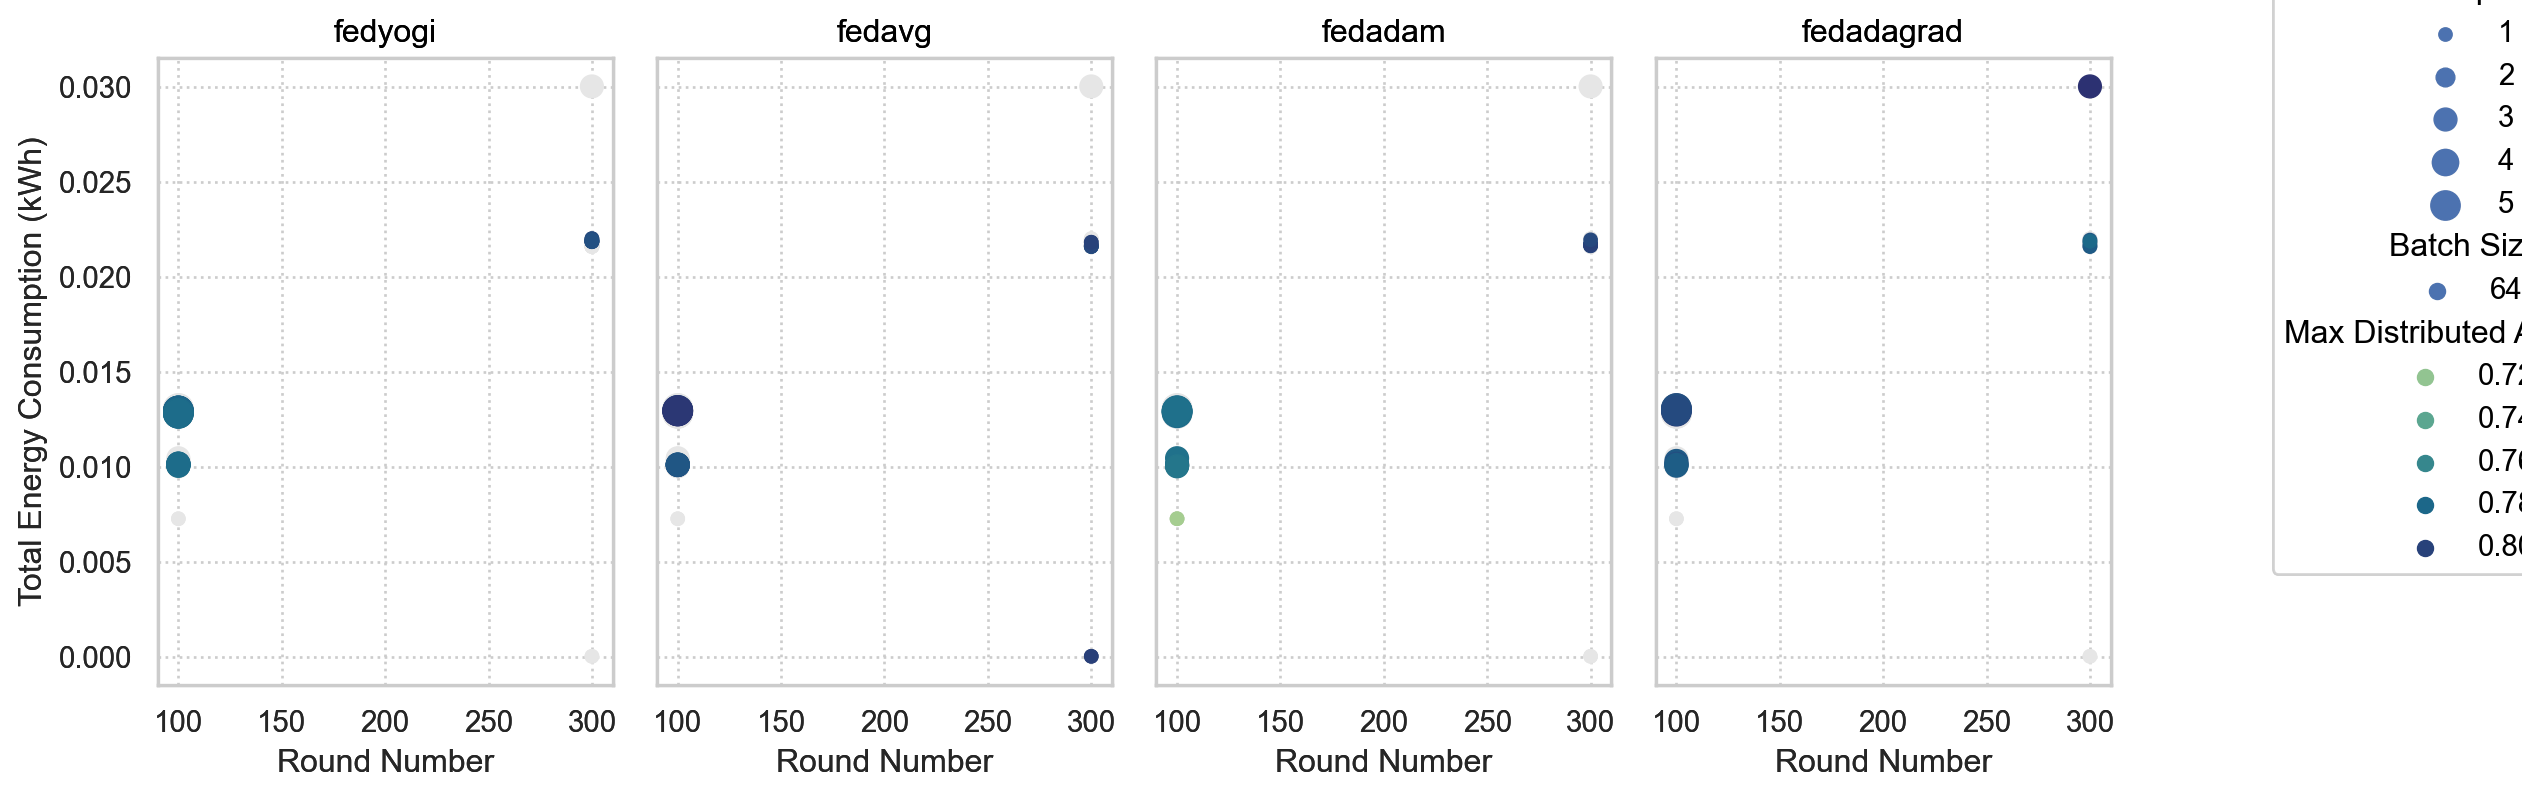

In [211]:
# plot_data = results_pq[(results_pq["round_number"].isin([30,100]))&(results_pq["max_distributed_accuracy"]>0.2)].compute() #[results["max_centralized_accuracy"]>0.1]
plot_data = results_pq[(results_pq["round_number"]<500)&(results_pq["max_distributed_accuracy"]>0.2)].compute() #[results["max_centralized_accuracy"]>0.1]
f = plt.Figure(figsize=(12, 5))
(
    so.Plot(
        plot_data, x="round_number", y="total_kWh",
        pointsize="client.local_epochs", color="max_distributed_accuracy",
        marker="data.batch_size",
    )
    .facet(
        col="strategy",
        # row="params.wait_round"
        )
    .add(so.Dot(color=".9"), col=None, color=None, row=None)
    .add(so.Dot())
    .scale(
        pointsize=(5, 11), 
        color="crest")
    .label(
        x="Round Number", 
        y="Total Energy Consumption (kWh)", 
        pointsize="Local Epochs", 
        color="Max Distributed Accuracy", 
        row="Wait Round: ", 
        marker="Batch Size",
        bbox_to_anchor=(1.05, 1),
        #col="Strategy:"
    )
    .layout(engine="tight")
    .on(f)
    .save("/Users/mathildepro/Documents/code_projects/FL-G5K-EnergyConsumption/graphs/experiment_perf_summaries_10clients.pdf", bbox_inches="tight")
)

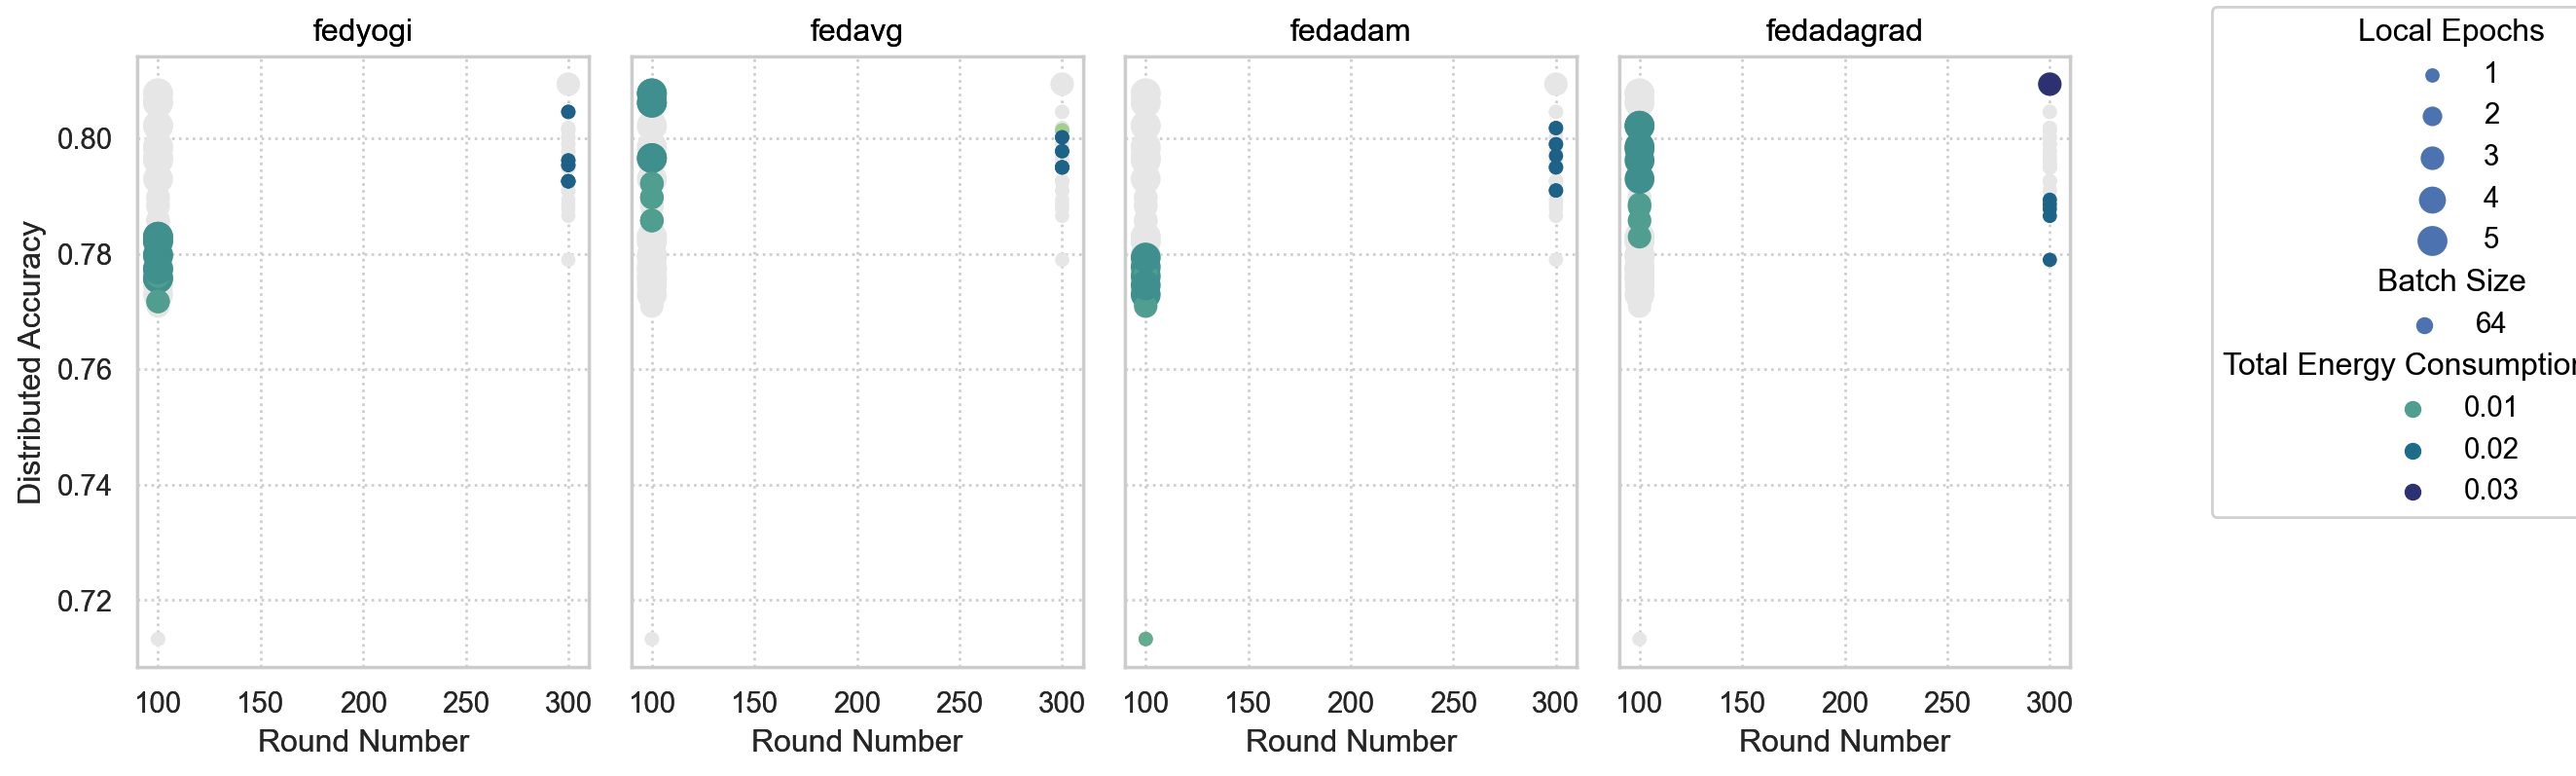

In [212]:
plot_data = results_pq[(results_pq["round_number"].isin([100,300]))&(results_pq["max_distributed_accuracy"]>0.2)].compute() #[results["max_centralized_accuracy"]>0.1]
plot_data = results_pq[(results_pq["round_number"]<500)&(results_pq["max_distributed_accuracy"]>0.2)].compute() #[results["max_centralized_accuracy"]>0.1]
f = plt.Figure(figsize=(12, 5))
(
    so.Plot(
        plot_data, x="round_number", y="max_distributed_accuracy",
        pointsize="client.local_epochs", color="total_kWh",
        marker="data.batch_size",
    )
    .facet(
        col="strategy",
        # row="params.wait_round"
        )
    .add(so.Dot(color=".9"), col=None, color=None, row=None)
    .add(so.Dot())
    .scale(
        pointsize=(5, 11), 
        color="crest")
    .label(
        x="Round Number", 
        y="Distributed Accuracy", 
        pointsize="Local Epochs", 
        color="Total Energy Consumption (kWh)", 
        row="Wait Round: ", 
        marker="Batch Size",
        bbox_to_anchor=(1.05, 1),
        #col="Strategy:"
    )
    .layout(engine="tight")
    .on(f)
    .save("/Users/mathildepro/Documents/code_projects/FL-G5K-EnergyConsumption/graphs/experiment_acc_summaries_10clients.pdf", bbox_inches="tight")
)

[Comments for march results]

Those last graphs show the relationship between the number of local epochs, the strategy, the number of rounds and the energy consumption. The main observation is that the algorithm needs a minimum number of local epochs to learn. For most strategy, 5 local epochs leads to no learning, and a max accuracy below 0.2. And for fedavg, the algorithm requires at least 20 local epochs to reach an accuracy higher than 0.6. 
Other observations:
- reaching an accuracy higher than 0.6 requires in average more energy and more rounds, which can be expected. It seems that there are only two scenarios: it doesn't learn at all and is stoped very early by wait_round, or it reaches the target accuracy 0.7. The second option systematically consumes more energy, but not significantly more. 
- The higher the number of local epochs, the higher the energy consumption. Even accross stragetes, the number of local epochs seems to be the most impactfull parameters regarding the total energy consumption. One exception is for fedavg and a lr of 0.05. 
- The number of rounds is not proportional to the energy consumption. Maybe we could have a look at the total number of local epochs (local epochs times the number of rounds)?

Il n'y a pas deux expériences avec les mêmes paramètres donc on ne peux pas savoir l'impact de la variabilité de l'entraînement : est ce que les différences entre les résultats sont dus aux paramètres ou aux aléa de l'entraînement ? Il faudrait faire tourner les experiences au moins 5 fois, quitte à mettre un early stopping sur le nombre de rounds et pas seulement avec le wait round. 

[Comments for april results]

For a given number of rounds, the total energy increases with the number of local numbers. However, a lower number of epochs require more round number and by consequences more energy in the end.
For the same amount of energy, fedadam and fedacg reach a higher accuracy.

## Studying energy per rounds

In [12]:
def style_round_role(role):
    return 'background-color:lightgreen;' if role == "train" else 'background-color:red;'

In [13]:
# training_results[(training_results["server_round"]<3)&(training_results["server_round"]>1)].groupby(["server_round", "hostname", "Client ID"]).first()[["round_role"]].style.map(style_round_role)

Sur une expérience de mars, en moyenne il y a 1.5 clients par hosts (si il y a un client actif sur le host) avec au maximum 5 clients actifs sur un host. 

En moyenne, les hosts sont actifs sur 35 rounds, sachant qu'il y en a 53. Donc ils sont actifs 66% du temps.

In [213]:
params = ["hostname", "server_round", "Client ID", "strategy", "params.wait_round", "params.num_rounds", "client.local_epochs"]
# fraction fit = 1 pour 10 clients, 0.1 pour 100 clients
ffit = 1
plot_df = round_pq[round_pq["params.fraction_fit"]==ffit].groupby(params)[["fittime"]].mean().reset_index().compute()
plot_df

,hostname,server_round,Client ID,strategy,params.wait_round,params.num_rounds,client.local_epochs,fittime
0,client_host_0,1,0,fedadam,100,100,1,16.862174
1,client_host_0,1,0,fedavg,100,100,3,30.758995
2,client_host_0,1,0,fedavg,100,100,5,45.022602
3,client_host_0,1,0,fedavg,300,3,1,20.109870
4,client_host_0,1,0,fedavg,300,300,1,16.422553
...,...,...,...,...,...,...,...,...
10925,client_host_9,298,9,fedyogi,300,300,1,7.242591
10926,client_host_9,299,9,fedavg,300,300,1,7.346333
10927,client_host_9,299,9,fedyogi,300,300,1,7.328364
10928,client_host_9,300,9,fedavg,300,300,1,7.379839


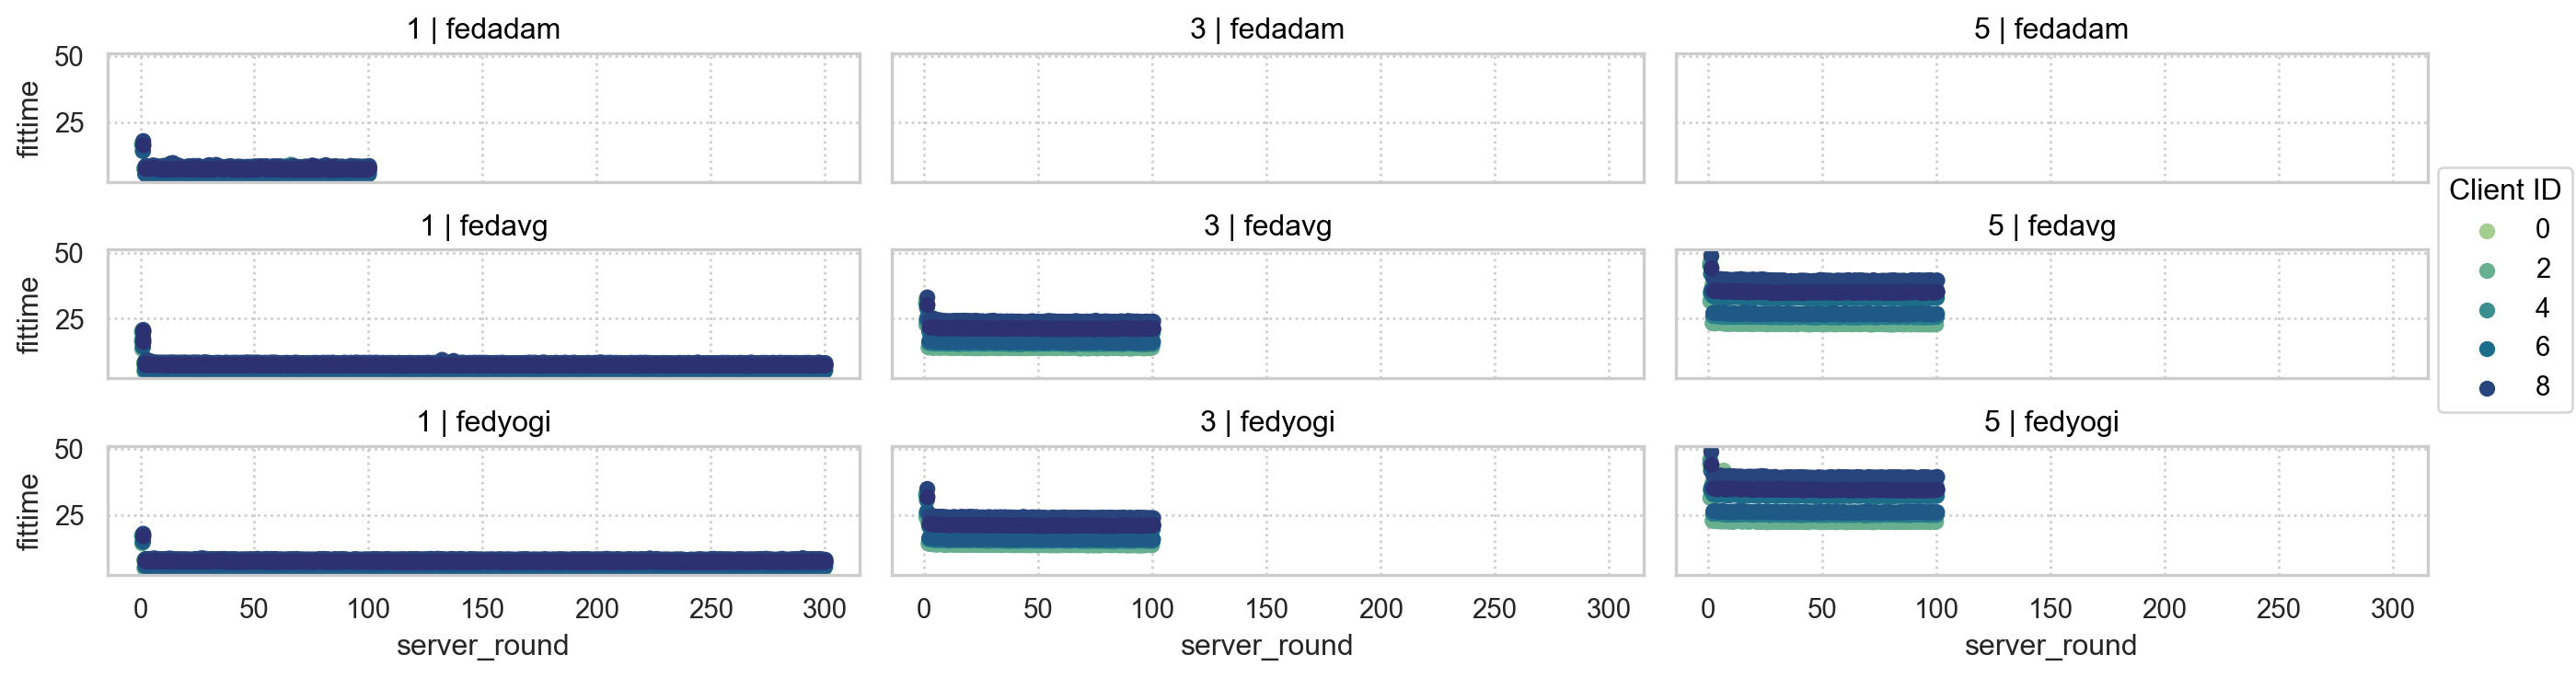

In [214]:
sf1 = plt.Figure(figsize=(14, 4))
(
    so.Plot(
        plot_df, x="server_round", y="fittime",
        #  pointsize="Client ID", 
         color="Client ID",
    )
    .facet(row="strategy", col="client.local_epochs")
    .add(so.Dot(), so.Dodge())
    .layout(engine="tight")
    .scale(color="crest", pointsize=(5, 11))
    # .label(x="Number of Clients per host", y="Training Time (s)", color="Host")
    .on(sf1)
)

The round time is higher when the number of local epochs increases.

In [215]:
params = ["hostname", "server_round", "Client ID", "strategy", "params.wait_round", "params.num_rounds","exp_id"]
plot_df = round_pq[(round_pq["params.fraction_fit"]==ffit)&(round_pq["client.local_epochs"]==3)].groupby(params)[["fittime"]].mean().reset_index().compute()
plot_df

,hostname,server_round,Client ID,strategy,params.wait_round,params.num_rounds,exp_id,fittime
0,client_host_0,1,0,fedavg,100,100,2024-04-23_23-12-04,30.794369
1,client_host_0,1,0,fedavg,100,100,2024-04-24_01-54-37,30.921794
2,client_host_0,1,0,fedavg,100,100,2024-04-24_04-36-51,30.560822
3,client_host_0,1,0,fedyogi,100,100,2024-04-16_20-26-17,35.527133
4,client_host_0,1,0,fedyogi,100,100,2024-04-16_23-09-36,30.245951
...,...,...,...,...,...,...,...,...
7995,client_host_9,100,9,fedyogi,100,100,2024-04-16_20-26-17,21.712356
7996,client_host_9,100,9,fedyogi,100,100,2024-04-16_23-09-36,20.928232
7997,client_host_9,100,9,fedyogi,100,100,2024-04-17_01-52-27,20.750916
7998,client_host_9,100,9,fedyogi,100,100,2024-04-17_04-35-00,21.067254


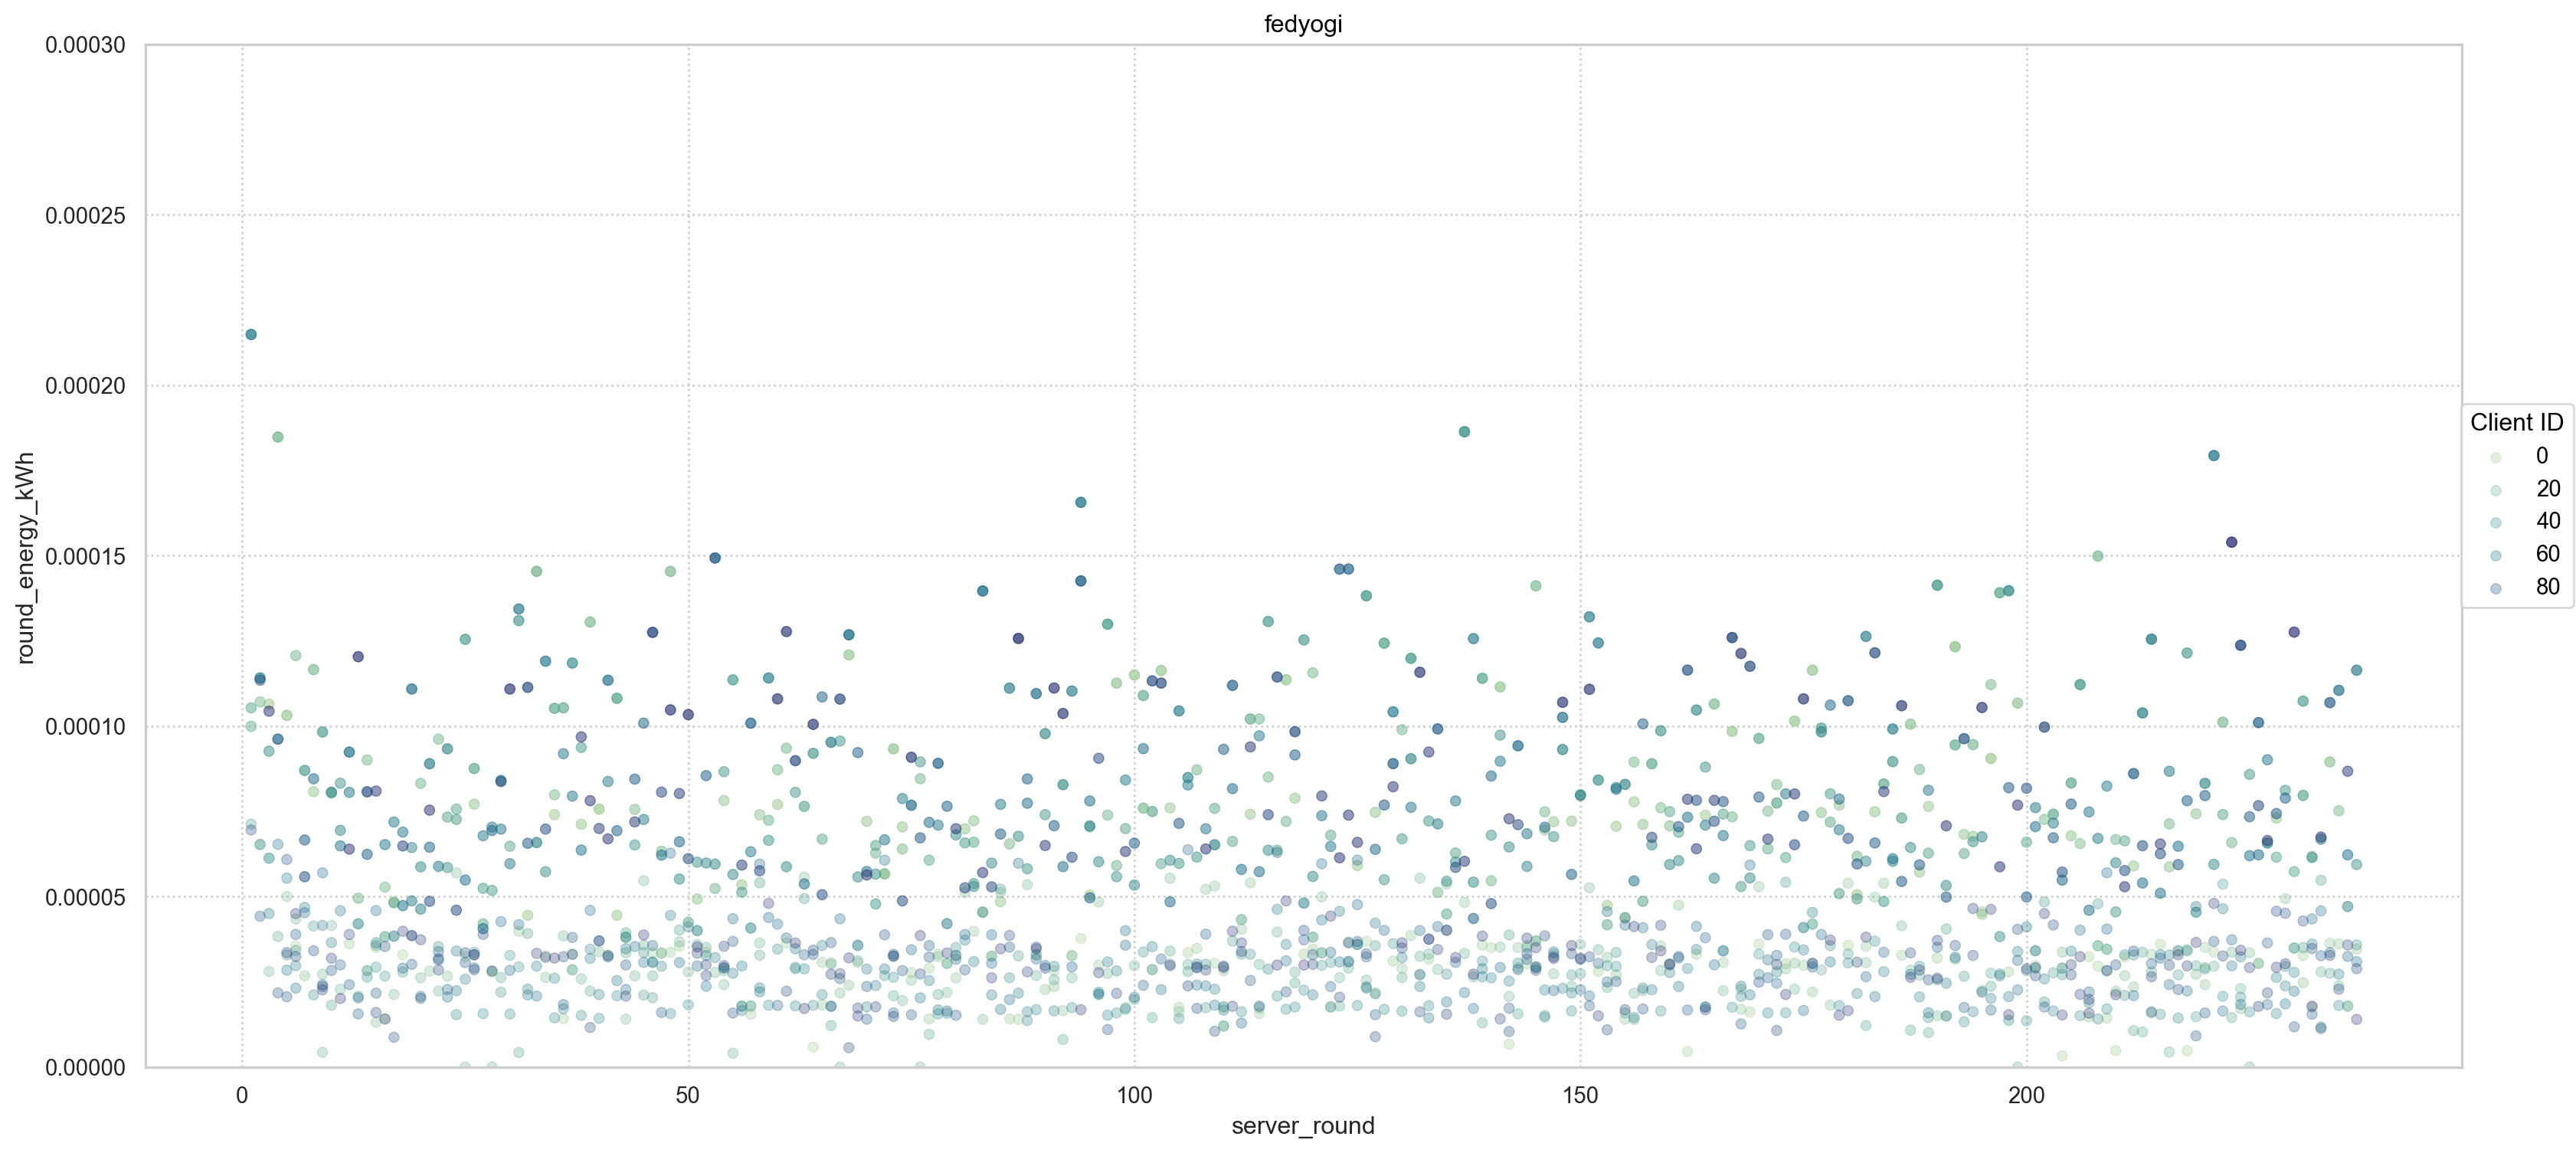

In [201]:
params = ["hostname", "server_round", "Client ID", "strategy", "params.wait_round", "params.num_rounds","exp_id"]
plot_df = round_pq[(round_pq["params.fraction_fit"]==ffit)&(round_pq["client.local_epochs"]==5)].groupby(params)[["round_energy_kWh"]].mean().reset_index().compute()

sf1 = plt.Figure(figsize=(17, 8))
(
    so.Plot(
        plot_df, x="server_round", y="round_energy_kWh",
        #  pointsize="Client ID", 
         color="Client ID",
    )
    .facet(col="strategy") #, row="Client ID")
    # .add(so.Line(linewidth=3), so.Agg()) #, so.Dodge())
    .add(so.Dot(alpha=0.3, pointsize=5))
    .limit(y=(0, 0.0003))
    .layout(engine="tight")
    .scale(color="crest", pointsize=(1, 2), edgecolor=None)
    # .label(x="Number of Clients per host", y="Training Time (s)", color="Host")
    .on(sf1)
)

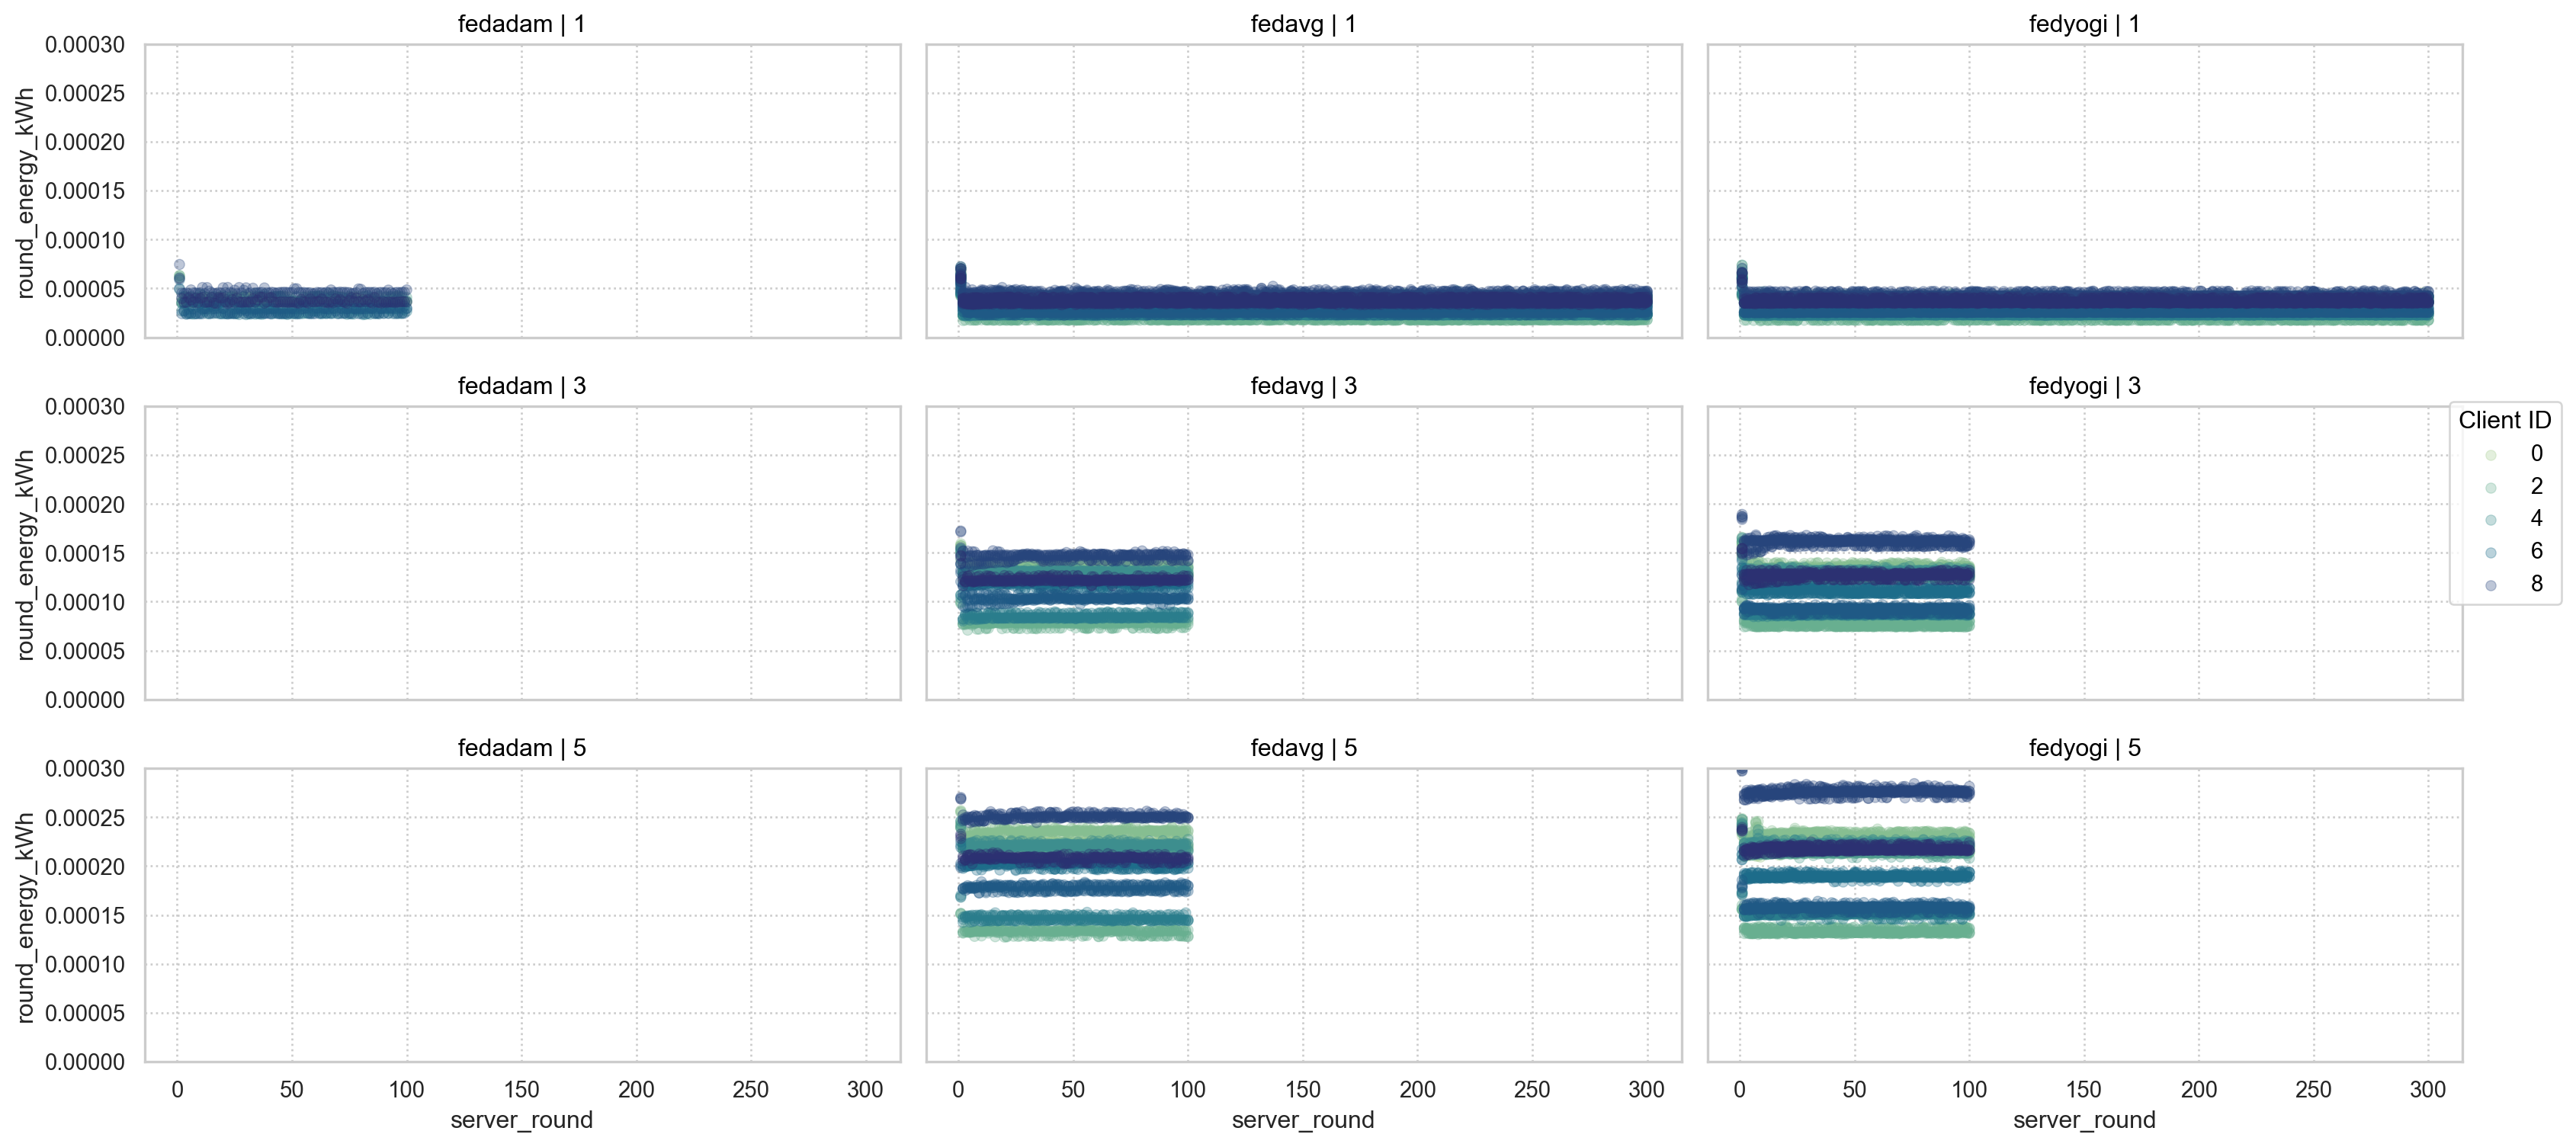

In [216]:
params = ["hostname", "server_round", "Client ID", "strategy", "params.wait_round", "params.num_rounds","exp_id","client.local_epochs"]
plot_df = round_pq[(round_pq["params.fraction_fit"]==ffit)&(round_pq["('fittime', 'count')"]==1)].groupby(params)[["round_energy_kWh"]].mean().reset_index().compute()

sf1 = plt.Figure(figsize=(17, 8))
(
    so.Plot(
        plot_df, x="server_round", y="round_energy_kWh",
        #  pointsize="Client ID", 
         color="Client ID",
    )
    .facet(col="strategy", row="client.local_epochs")
    # .add(so.Line(), so.Agg()) #, so.Dodge())
    .add(so.Dot(alpha=0.3, pointsize=5))
    
    .limit(y=(0, 0.0003))
    .layout(engine="tight")
    .scale(color="crest", pointsize=(1, 2), edgecolor=None)
    # .label(x="Number of Clients per host", y="Training Time (s)", color="Host")
    .on(sf1)
)

The training round energy consumption is highly impacted by the client ID. 
If you were able to correlate this with the size of the client database that would be amazing.

/Users/mathildepro/miniforge3/envs/energy_analysis/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


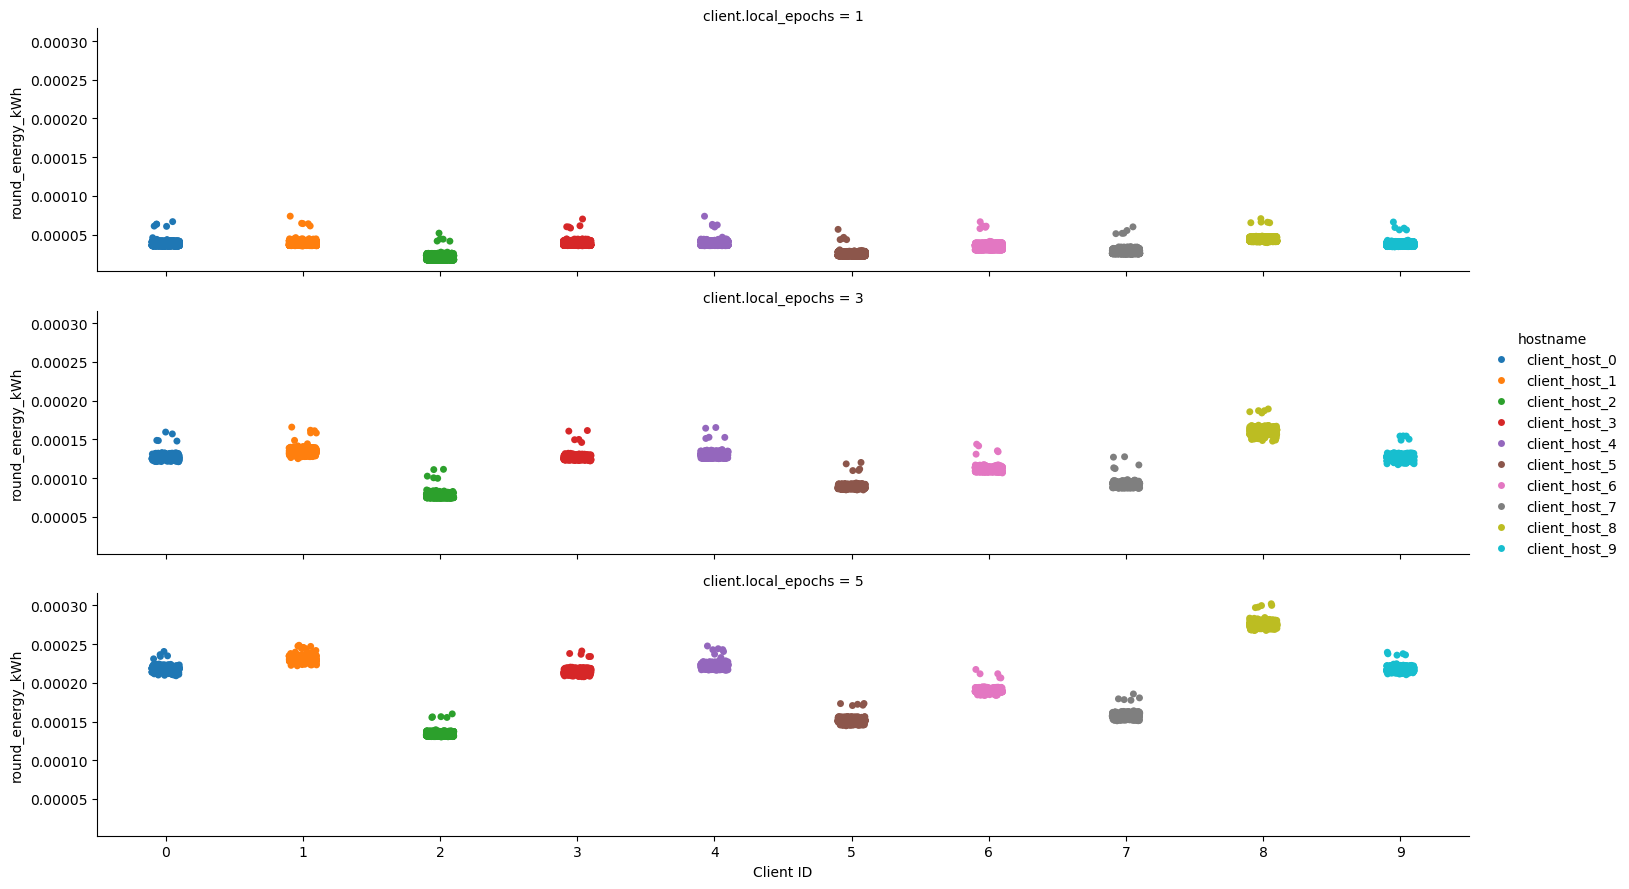

In [217]:
import seaborn as sns
g = sns.catplot(
    data=plot_df[plot_df["strategy"]=="fedyogi"],
    x="Client ID", 
    y="round_energy_kWh", 
    row="client.local_epochs", 
    hue="hostname",
    height=3,
    aspect=5,
)
# g.savefig("/Users/mathildepro/Documents/code_projects/FL-G5K-EnergyConsumption/graphs/round_energy_kWh_vs_clientID_100clients.pdf")

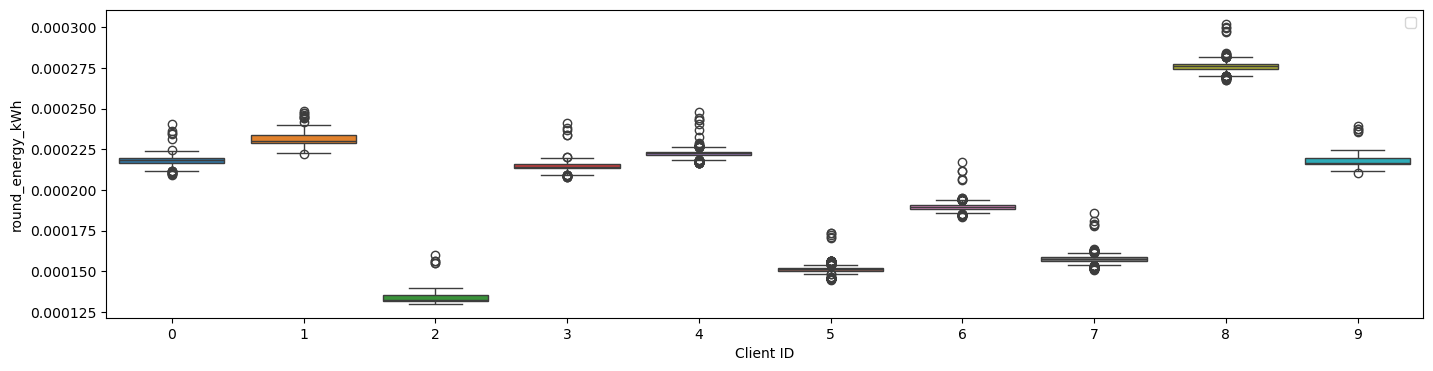

In [218]:

fig, ax = plt.subplots(figsize=(17, 4))
sns.boxplot(
    ax=ax, x="Client ID", y="round_energy_kWh",data=plot_df[(plot_df["strategy"]=="fedyogi")&(plot_df["client.local_epochs"]==5)], hue="hostname",
    )
ax.legend('')
# plt.savefig("/Users/mathildepro/Documents/code_projects/FL-G5K-EnergyConsumption/graphs/round_energy_kWh_vs_clientID_10clients_10local_epochs_yogi.pdf")

Just another way of visualizing it.

<Axes: xlabel='hostname', ylabel='round_energy_kWh'>

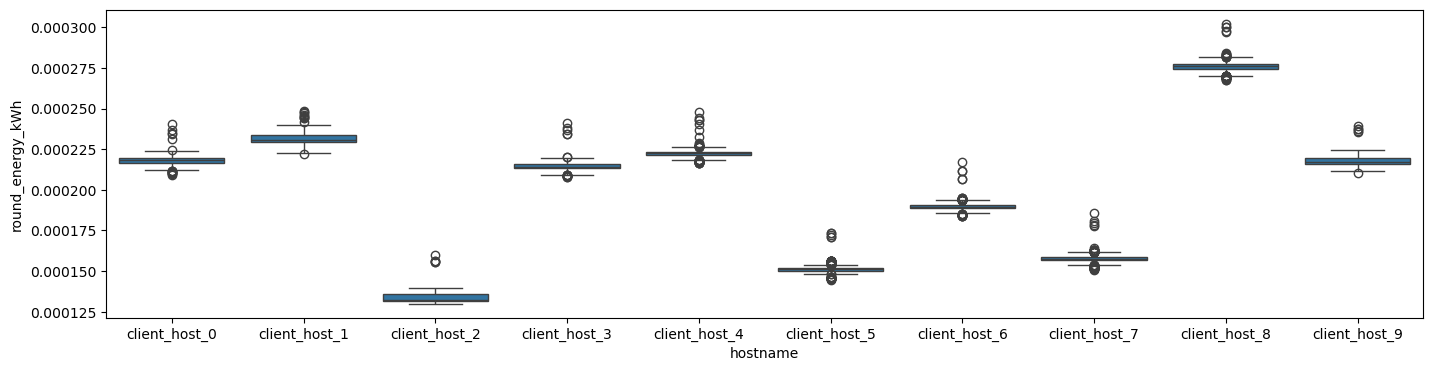

In [190]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(17, 4))
sns.boxplot(ax=ax, x="hostname", y="round_energy_kWh", data=plot_df[(plot_df["strategy"]=="fedyogi")&(plot_df["client.local_epochs"]==5)])

if you are looking at several-client-per-host experiments, this graphs shows the average per host

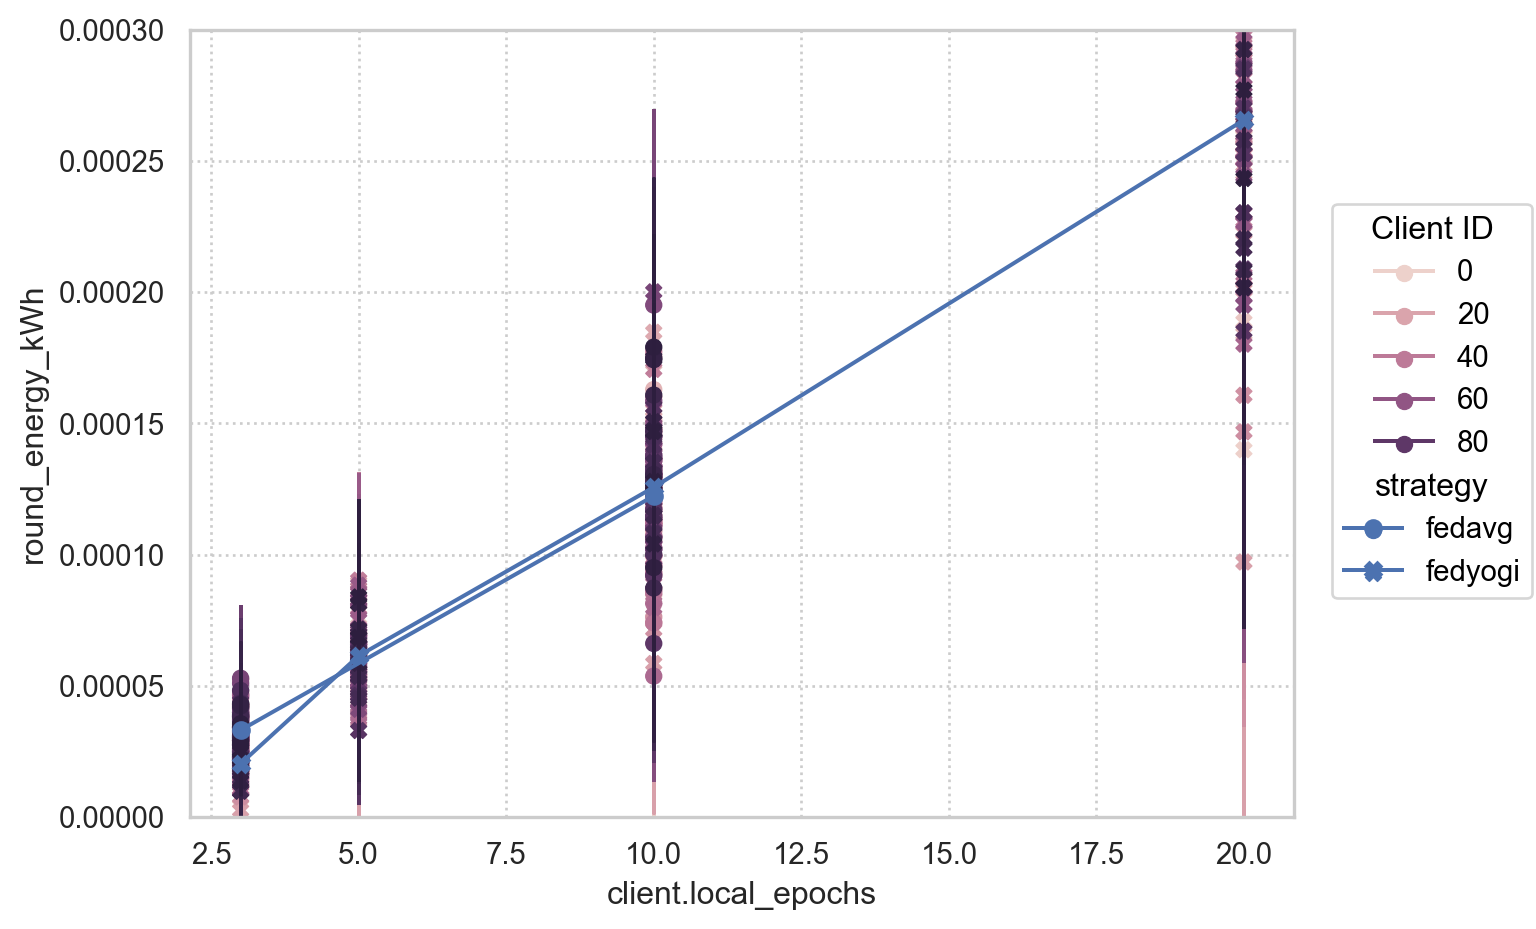

In [80]:
params = ["hostname", "server_round", "Client ID", "strategy", "params.wait_round", "params.num_rounds","exp_id", "client.local_epochs"]
plot_df = round_pq[(round_pq["params.fraction_fit"]==ffit)].groupby(params)[["round_energy_kWh"]].mean().reset_index().compute()

sf1 = plt.Figure(figsize=(7, 5))
(
    so.Plot(
        plot_df, x="client.local_epochs", y="round_energy_kWh",
         color="Client ID",marker="strategy"
    )
    # .add(so.Dot(), so.Agg(), so.Dodge())
    .add(so.Dot(),so.Agg()) #, so.Dodge()) 
    .add(so.Range(), so.Est(errorbar="sd")) #, so.Dodge())
    .add(so.Line(), so.Agg(), color=None)
    # .scale(color="tab10", pointsize=(1, 2), edgecolor=None)
    # .add(so.Dot(marker="+", pointsize=100, edgewidth=100), so.Agg(), color=None)
    .limit(y=(0, 0.0003))
    .layout(engine="tight")
    # .label(x="Number of Clients per host", y="Training Time (s)", color="Host")
    .on(sf1)
)

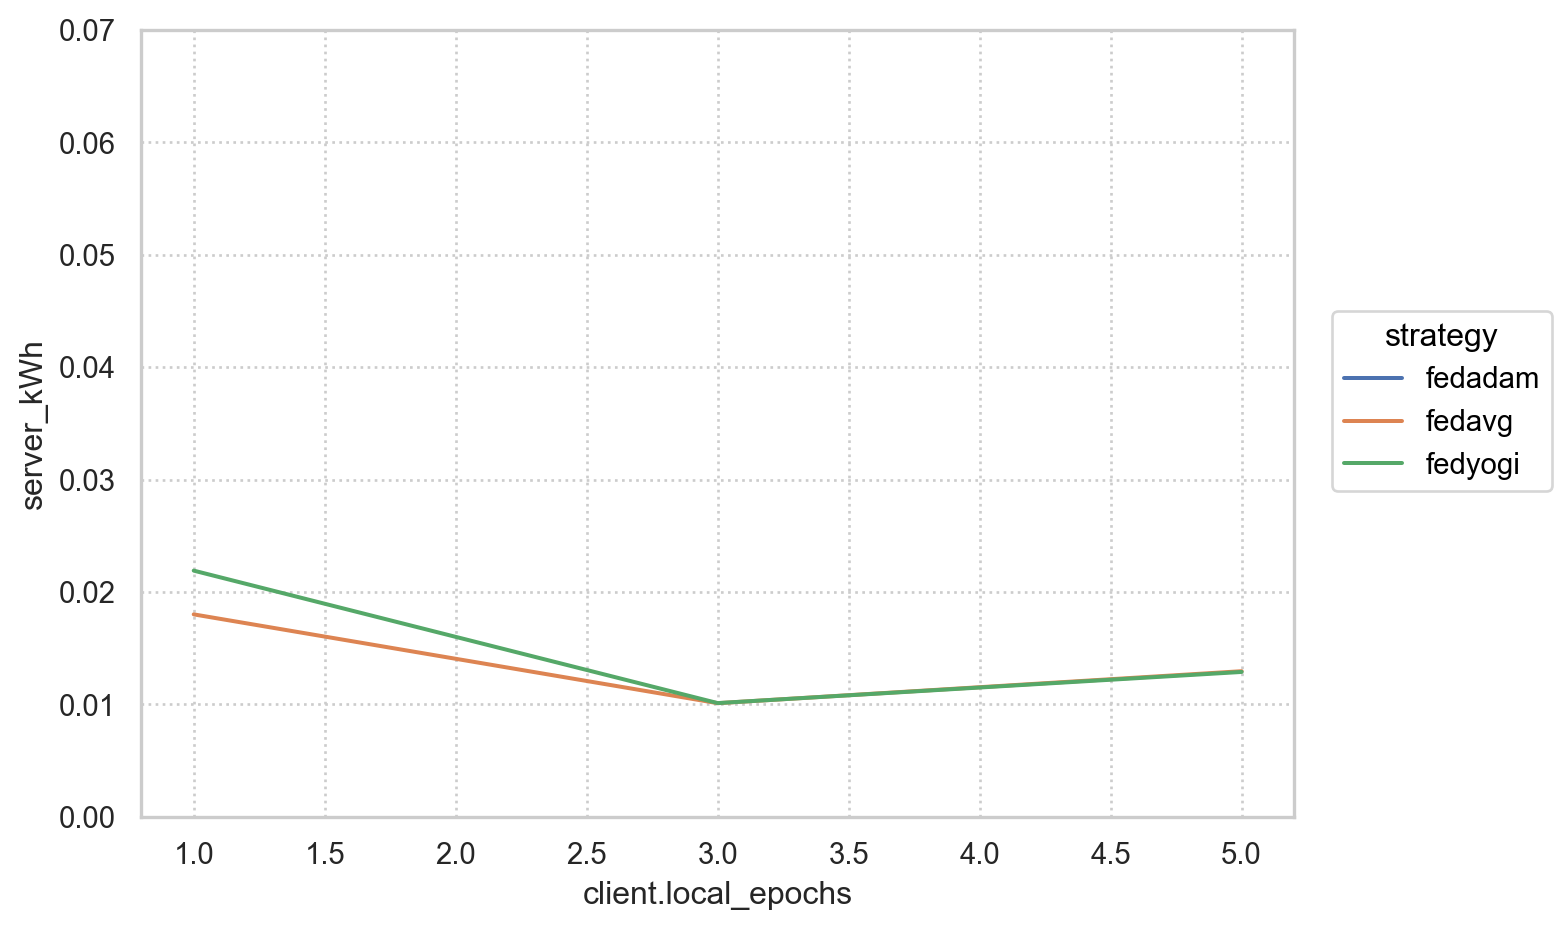

In [ ]:
params = ["hostname", "server_round", "Client ID", "strategy", "params.wait_round", "params.num_rounds","exp_id", "client.local_epochs"]
plot_df = round_pq[(round_pq["params.fraction_fit"]==ffit)].groupby(params)[["server_kWh"]].mean().reset_index().compute()

sf1 = plt.Figure(figsize=(7, 5))
(
    so.Plot(
        plot_df, x="client.local_epochs", y="server_kWh",
        color="strategy"
    )
    # .add(so.Range(), so.Est(errorbar="sd"))
    .add(so.Line(), so.Agg())
    # .add(so.Dot(), so.Dodge())
    .limit(y=(0, 0.07))
    .layout(engine="tight")
    .on(sf1)
)

In [116]:
c_df = round_pq[(round_pq["params.fraction_fit"]==ffit)&(round_pq["('fittime', 'count')"]==1)]
c_df["round_server_kWh"] = c_df["server_kWh"] / c_df["round_number"]
c_df = c_df[c_df["round_number"]>10].groupby(["data.num_clients","Client ID", "client.local_epochs", "strategy"])[["round_energy_kWh", "server_kWh", "round_server_kWh"]].mean().reset_index()
c_df.compute().to_csv("stats.csv") #.to_clipboard()

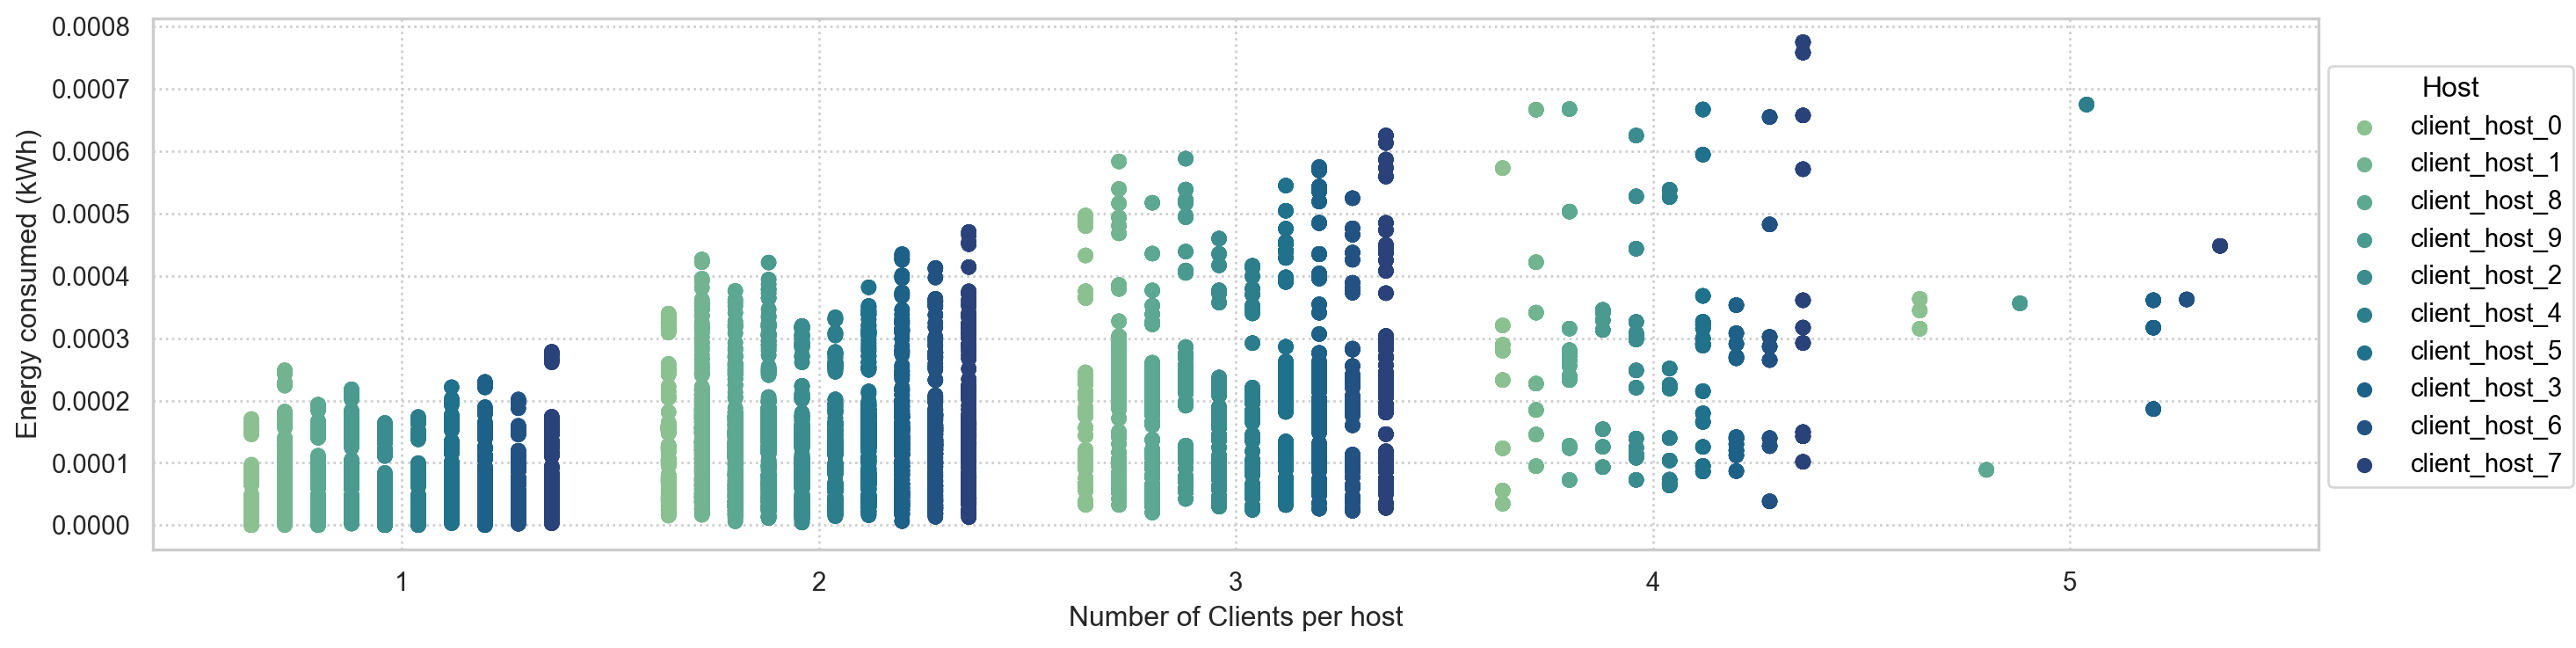

In [63]:
sf1 = plt.Figure(figsize=(14, 4))
(
    so.Plot(
        # fittime_stats[fittime_stats["server_round"]<12], x="server_round", y="fittime",
        # pointsize=('fittime', 'count'), color="Client ID",
        round_pq.compute(), x="('fittime', 'count')", y="round_energy_kWh",
        color="hostname",
    )
    # .facet(col=('fittime', 'count'))
    .add(so.Dot(), so.Dodge())
    .layout(engine="tight")
    .scale(color="crest", pointsize=(5, 11))
    .label(x="Number of Clients per host", y="Energy consumed (kWh)", color="Host")
    .on(sf1)
)

[Comments from march experiments]

Here we can see that in average the training time increases with the number of client per host. However there are always outliers with a training time twice as long. It doesn't seem to be related to the client or the host anyway. The variance doesn't seem to be increasing with the number of client per host.

It seems that the training time increases with the server round.

ok one thing that's sure is that the training time is different for two client training at the same time on the same host. so what do we do? I guess we are going to need to look at the processes. In the midtime, we can gather the energy between the minimum start time and maximum end time.

un peu plus de variabilité avec l'énergie : les hosts ne consomment pas pareil (c'est attendu).
mais on voit bien que plus il y a de client par host plus la consommation d'énergie est forte, elle est même presque proportionnelle.

TODO : répartir l'énergie par clients et voir si on est équivalent


In [125]:
import pandas as pd
df = pd.read_csv("/Users/mathildepro/Documents/code_projects/FL-G5K-EnergyConsumption/graphs/stats.csv")
df.dtypes

data.num_clients         int64
Client ID                int64
client.local_epochs      int64
strategy                object
server_kWh             float64
round_energy_kWh       float64
round_server_kWh       float64
dtype: object

In [165]:
df["energy_per_epoch"]=df["round_energy_kWh"]/df["client.local_epochs"]

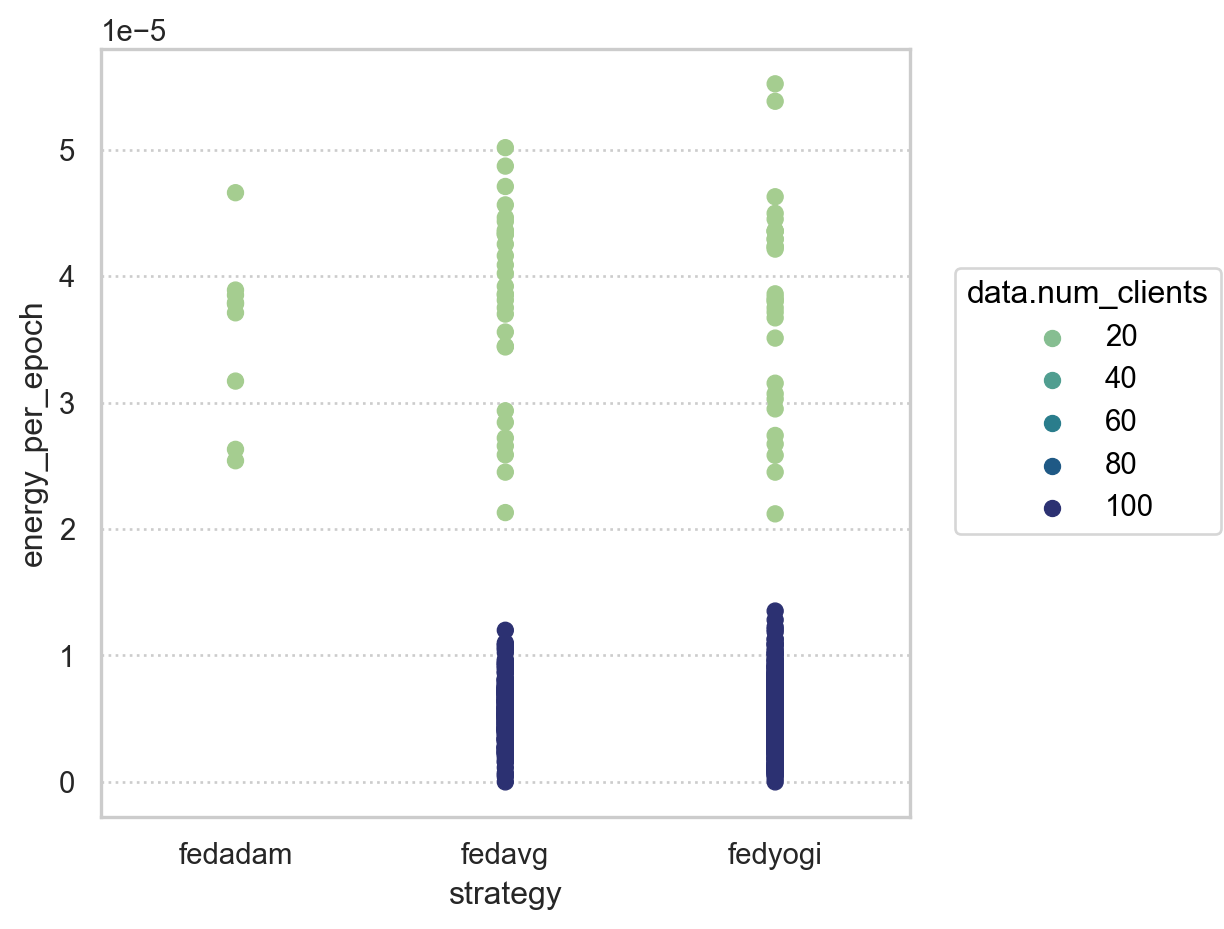

In [170]:
sf1 = plt.Figure(figsize=(5, 5))
(
    so.Plot(
        df, #df["client.local_epochs"].isin([3,5])], 
        y="round_energy_kWh",
        x="client.local_epochs", 
        marker = "strategy",
        # marker="strategy", 
        color="data.num_clients"
    )
    # .facet(
    #     row="strategy",
    #     col="data.num_clients"
    #     )
    .add(so.Dot())
    # .add(so.Range(), so.Agg(), so.Dodge(), )
    # .add(so.Range(), so.Est(errorbar="sd"), so.Dodge()) 
    .layout(engine="tight")
    .scale(color="crest", pointsize=(5, 8))
    # .label(x="Number of Clients per host", y="Energy consumed (kWh)", color="Host")
    .on(sf1)
    # .save("/Users/mathildepro/Documents/code_projects/FL-G5K-EnergyConsumption/graphs/round_energy_kWh_vs_local_epochs.pdf", bbox_inches="tight")
)

In [220]:
df.groupby(["data.num_clients", "client.local_epochs", "strategy"])[["round_energy_kWh"]].mean() #.reset_index().to_clipboard()

round_energy_kWh
data.num_clients client.local_epochs strategy                  
10               1                   fedadam           0.000036
                                     fedavg            0.000034
                                     fedyogi           0.000034
                 3                   fedavg            0.000118
                                     fedyogi           0.000118
                 5                   fedavg            0.000202
                                     fedyogi           0.000201
100              3                   fedavg            0.000015
                                     fedyogi           0.000008
                 5                   fedyogi           0.000029
                 10                  fedavg            0.000064
                                     fedyogi           0.000065
                 20                  fedyogi           0.000138